In [19]:
import torch
import numpy as np
import os
import cma
from eval import play
from gan.config import SmallModelConfig
from gan.small_models import Generator
from gan.utils import tensor_to_level_str,check_playable
from gan.level_visualizer import LevelVisualizer
from play_rl.env import Env
from play_rl.wrappers import GridGame
from play_rl.policy import Policy
from PIL import Image

In [20]:
config = SmallModelConfig()
config.set_env()
config.cuda = False
if config.cuda:
    device = torch.device(
        "cuda" if torch.cuda.is_available else "cpu")
    print("device : cuda")
else:
    device = torch.device("cpu")
    print("device : cpu")
generator = Generator(
    out_dim=config.input_shape[0],
    shapes=config.model_shapes,
    z_shape=(config.latent_size,),
    filters=config.generator_filters,
).to(device)
env_def = Env(config.env_name,config.env_version)
level_visualizer = LevelVisualizer(env=env_def)

model_path = os.path.join(
    "/root/mnt/GVGAI-GAN/gan/checkpoints/none-866", "models_1160.tar")
load_model = torch.load(model_path)
generator.load_state_dict(load_model["generator"])
x = torch.randn(config.latent_size).to(device)


device : cpu


Connecting to host 127.0.0.1 at port 40769 ...
Client connected to server [OK]
(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=956889, Tue Aug 30 08:20:56 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 1.000000000000000e+02 1.0e+00 4.69e-01  5e-01  5e-01 0:00.1
    2     28 -3.580000000000000e+02 1.1e+00 4.55e-01  4e-01  5e-01 0:09.2
    3     42 -1.000000000000000e+02 1.1e+00 4.47e-01  4e-01  5e-01 0:13.7
    6     84 -3.110000000000000e+02 1.2e+00 4.60e-01  5e-01  5e-01 0:20.6
    7     98 -2.340000000000000e+02 1.2e+00 4.74e-01  5e-01  5e-01 0:25.1
    8    112 -2.330000000000000e+02 1.2e+00 4.74e-01  5e-01  5e-01 0:32.7
   10    140 -2.370000000000000e+02 1.3e+00 4.90e-01  5e-01  5e-01 0:48.1
INIT:  [ 0.01039747  1.58098638 -1.20620728  1.04800534  0.02469879 -1.33030629
  0.70263982  1.71118546  1.82350349 -1.4710449  -1.04521036 -0.939987
 -2.47386646  1.09412241  0.55837882  2.58600783 -1.6364876  -0.35809794
  0.17221154  0.

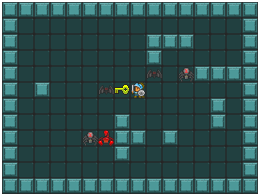

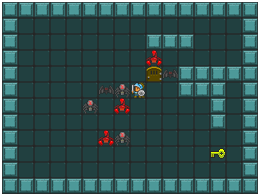

In [22]:
def eval(level_str):
    wall = 0
    enemy = 0
    for i, s in enumerate(level_str):
        for j, c in enumerate(s):
            if c == 'w':
                wall += 1
            if c in ['1', '2', '3']:
                enemy += 1
    return wall + enemy*10


env = GridGame(config.env_name, 200, env_def.state_shape)
actor = Policy(env.observation_space.shape, env.action_space,base_kwargs={"recurrent": True})
actor.load_state_dict(torch.load('/root/mnt/GVGAI-GAN/play_rl/checkpoints/ppo/zelda_20220825102126.pt'))

def fitness(x: torch.Tensor):
    x = np.array(x)
    latent = torch.FloatTensor(x).view(1, -1, 1, 1)
    level = generator(latent)
    level_str = tensor_to_level_str('zelda', level)
    playable = check_playable(level_str[0])
    if not playable:
        return 100
    reward,step,_ = play(level_str[0],env=env,actor=actor)
    return -(reward*100+step)
    # ev = eval(level_str)
    # return -ev

def show(x):
    p_level = torch.nn.Softmax2d()(generator(x))
    level_strs = tensor_to_level_str(
        config.env_name, p_level)
    p_level_img = np.array(level_visualizer.draw_level(level_strs[0]))
    image = Image.fromarray(p_level_img)
    image.show()

es = cma.CMAEvolutionStrategy(x.tolist(), 0.5)
es.optimize(fitness,iterations=10,min_iterations=10)
best = np.array(es.best.get()[0])
print("INIT: ", np.array(x.tolist()))
print("BEST: ", best)
print("Fitness: ", fitness(best))

show(x)
show(torch.FloatTensor(best))
